In [49]:
from mppi import Utilities as U, Parsers as P
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import numpy as np
from scipy.signal import argrelextrema
import scipy.optimize
import yaml

# Plots

This notebook collects the script for the plots.

## Decay constant from the echo peaks

We measure the physical dephasing time from the height and time position of the echo peaks.

In [68]:
file = 'echo_results/echo_decay.yaml'
eta = 4e-4

In [69]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'ref', 'time'])

In [70]:
time = np.array(data_loaded['time'])
ref = np.array(data_loaded['ref'])
echo = data_loaded['echo']

for tau in echo:
    echo[tau] = np.array(echo[tau])

In [71]:
echo.keys()

dict_keys(['0.5ps', '1.5ps', '1ps', '2.5ps', '2ps'])

We build the expected exponential decay of the polarization, starting from the its peak

In [72]:
ind_max = np.argmax(ref)
pol_peak = ref[ind_max]
time_exp = time[ind_max:]
exp_decay = pol_peak*np.exp(-eta*(time_exp-time_exp[0]))

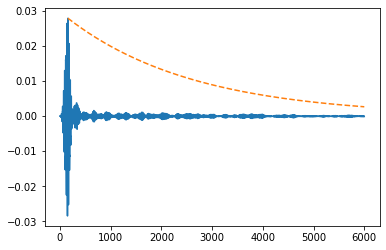

In [73]:
plt.plot(time,ref)
plt.plot(time_exp,exp_decay,linestyle='--')

We perform the exponential fit of the echo peaks

In [118]:
tmax = []
echo_max = []
for tau in echo:
    tmax.append(time[np.argmax(echo[tau])])
    echo_max.append(max(echo[tau]))
tmax = np.array(tmax)
echo_max = np.array(echo_max)
tmax,echo_max

(array([1150. , 3130. , 2150. , 5127.5, 4127.5]),
 array([9.16570749e-05, 3.82582053e-05, 5.68868798e-05, 1.75596623e-05,
        2.55730678e-05]))

In [119]:
#def monoExp(t, x0, eta):
#    return x0 * np.exp(-t * eta)
def monoExp(t, x0):
    return x0 * np.exp(-t * eta)

In [121]:
#p0 = (1.5e-4, eta) # start with values near those we expect
p0 = (1.5e-4) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, tmax, echo_max, p0)
#x0, eta_fit = params
x0 = params

In [122]:
params

array([0.00014037])

In [123]:
#exp_fit = monoExp(time_exp,x0,eta_fit)
exp_fit = monoExp(time_exp,x0)

In [138]:
#plt.axvline?

In [145]:
(monoExp(tmax,x0)-e_min)/(e_max-e_min)

array([0.65444672, 0.49317665, 0.55725936, 0.41970945, 0.44924636])

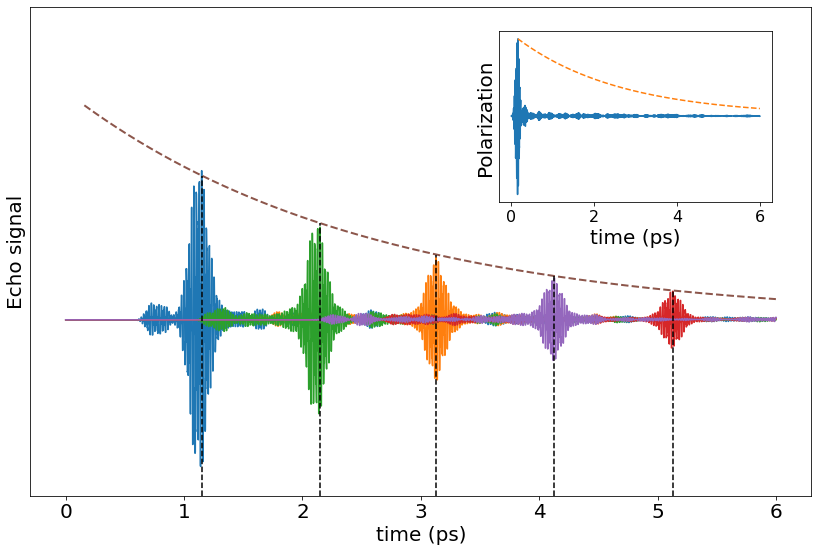

In [149]:
label_size = 20
e_min = min(echo['0.5ps'])*1.2
e_max = max(echo['0.5ps'])*2.1

fig, ax1 = plt.subplots(figsize=(14, 9))

for t in echo:
    ax1.plot(time*1e-3,echo[t],label='echo_'+t)
ax1.plot(time_exp*1e-3,exp_fit,linestyle='--',linewidth=2)
for tm in tmax:
    ax1.axvline(tm*1e-3,ymax=(monoExp(tm,x0)-e_min)/(e_max-e_min),color='black',ls='--') #
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('Echo signal',size=label_size)
ax1.set_ylim(e_min,e_max)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.6,0.6,0.35,0.35])
ax2.set_axes_locator(ip)
#ax2.plot(energy_exp,eps2_exp)
ax2.plot(time*1e-3,ref)
ax2.plot(time_exp*1e-3,exp_decay,linestyle='--')
ax2.set_yticks([])
ax2.set_xlabel('time (ps)',size=label_size)
ax2.set_ylabel('Polarization',size=label_size)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='jdos_cv.eps',format='eps',bbox_inches = "tight")